# Project 3: Applying CNNs

Project based on image classification using CNNs. The model below will classify an image as containing the officially licensed Razorback or not.

In [1]:
#Cell 1 - Imports for CNN image classification

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import random


Classes: ['Not_Razorback', 'Razorbacks']
Total images: 50
Training images: 35
Testing images: 15


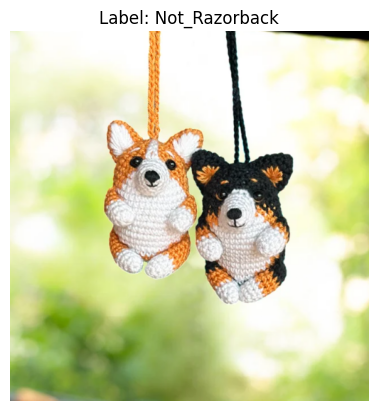

In [3]:
#Cell 2 — Initial Data loading to verify images are read correctly

#Path to images
#Heirarchy: ./Not_Razorback/*.png and ./Razorbacks/*.png
data_path = './'

#For now, only convert images to tensors. Resizing will be added later
basic_transform = transforms.ToTensor()

#Use ImageFolder since we have folder-per-class structure. Makes the classification of the images really simple
dataset = datasets.ImageFolder(root=data_path, transform=basic_transform)

# Split into train/test (70/30 split)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#Information about the dataset
print("Classes:", dataset.classes)
print(f"Total images: {len(dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Testing images: {len(test_dataset)}")

#Display a sample image to confirm reading works
sample_img, sample_label = dataset[12]
plt.imshow(np.transpose(sample_img.numpy(), (1, 2, 0)))
plt.title(f"Label: {dataset.classes[sample_label]}")
plt.axis("off")
plt.show()


In [ ]:
#Cell 3 - Initialize randomness

#I liked how the CelebA notebook initialized randomness.
#I'll be mimicking that here, as well as the resizing.
#I found that just replacing the dataset with the transformed one was easiest.
#Perhaps not practical for huge datasets, but fine for this small one.

train_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor()
])

#Reload dataset with NO transforms, so transforms only apply in splits
full_dataset = datasets.ImageFolder(root='./')

#Create train/test split
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_subset, test_subset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

#Apply transforms to each split
train_dataset = datasets.ImageFolder(root='./', transform=train_transform)
test_dataset = datasets.ImageFolder(root='./', transform=test_transform)

#ImageFolder loads the full dataset; we need to map the subset
train_dataset.samples = [full_dataset.samples[i] for i in train_subset.indices]
test_dataset.samples = [full_dataset.samples[i] for i in test_subset.indices]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Augmented dataset ready.")
print("Train images:", len(train_dataset))
print("Test images:", len(test_dataset))
print("Classes:", train_dataset.classes)


Augmented dataset ready.
Train images: 35
Test images: 15
Classes: ['Not_Razorback', 'Razorbacks']


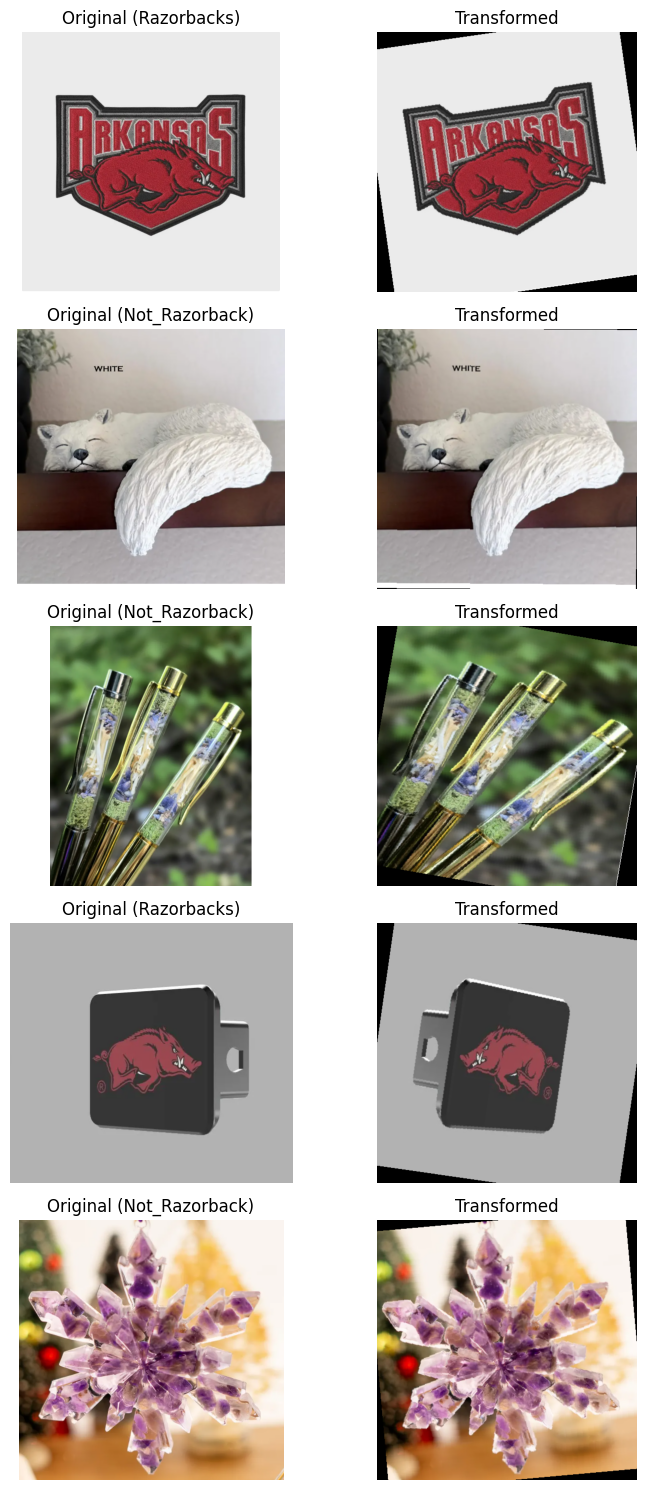

In [8]:
#Cell 4 — Visualize augmentation

#How many images to visualize
num_images = 5

#Sample indices from the full dataset
indices = random.sample(range(len(full_dataset)), num_images)

fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 3))

for i, idx in enumerate(indices):
    #Load original image
    img_path, label = full_dataset.samples[idx]
    original = Image.open(img_path).convert("RGB")
    
    #Apply train transform (randomness)
    transformed = train_transform(original)

    #Convert transformed image back to numpy for plotting
    transformed_np = np.transpose(transformed.numpy(), (1, 2, 0))

    # --- Left column: original image ---
    axes[i, 0].imshow(original)
    axes[i, 0].set_title(f"Original ({full_dataset.classes[label]})")
    axes[i, 0].axis("off")

    # --- Right column: transformed image ---
    axes[i, 1].imshow(transformed_np)
    axes[i, 1].set_title("Transformed")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
#Cell 5 - Define CNN model

#pulled straight from CelebA example

#For the next few cells, using the same architecture first, 
#then changing if improvements are needed

# •	Use nn.Sequential() to build a stack of layers.
# •	Layer 1: Conv2d(3→32) → ReLU → MaxPool → Dropout.
# •	Layer 2: Conv2d(32→64) → ReLU → MaxPool → Dropout.
# •	Layer 3: Conv2d(64→128) → ReLU → MaxPool.
# •	Layer 4: Conv2d(128→256) → ReLU.
# •	Purpose: progressively extract hierarchical features from images.

model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=0.5))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.5))

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())

In [10]:
#Cell 6 - Verify model architecture with dummy data

#pulled straight from CelebA example

# •	Create a batch of 4 dummy images (64×64 RGB).
# •	Pass through model to verify output shape.
# •	Purpose: sanity check for layer compatibility.

x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256, 8, 8])

In [11]:
#Cell 7 - Complete model with pooling and flattening

#pulled straight from CelebA example

# •	AvgPool2d(kernel_size=8): global average pooling to summarize spatial features.
    # • This CAN be removed, although the code would need to be modified. For instance we would need to adjust the next layer to accept a larger input.
# •	Flatten(): convert 2D feature maps into 1D vector for fully connected layers.
# •	Test output shape with dummy input.

model.add_module('pool4', nn.AvgPool2d(kernel_size=8))

model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256])

In [12]:
#Cell 8 - Finalize model with fully connected and sigmoid layers

#pulled straight from CelebA example

# •	Linear(256→1): map features to single output in the fully connected layer.
# •	Sigmoid(): convert output to probability for binary classification.

model.add_module('fc', nn.Linear(256, 1))

model.add_module('sigmoid', nn.Sigmoid())

In [13]:
#Cell 9 - Final model verification with dummy data

#pulled straight from CelebA example

# •	Forward pass with dummy input.
# •	Ensure output shape is (batch_size, 1).
# •	Does provide expected size

x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 1])

In [ ]:
#Cell 10 - Print model architecture

#pulled straight from CelebA example

# •	Prints all layers in the model for verification.

model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
#Cell 11 - Set device for model training

#pulled straight from CelebA example

# •	Select cuda if available, else cpu.
# •	Move model to the selected device to ensure computations occur on the same device as input.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [16]:
#Cell 12 - Define loss function and optimizer

#pulled straight from CelebA example

# • nn.BCELoss(): binary cross-entropy for binary classification.
# •	torch.optim.Adam: optimizer with learning rate 0.001 to update parameters.
loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#Cell 13 - Training loop function

#pulled straight from CelebA example

# •	Function train(model, num_epochs, train_dl, valid_dl) encapsulates the training loop.
# •	Initialize history lists for loss and accuracy.
# •	Loop over epochs:
    # •	Set model to train mode.
    # •	Forward pass on training batches, compute loss, backpropagate, optimizer step, reset gradients.
    # •	Accumulate loss and accuracy.
    # •	Set model to eval mode and compute validation metrics.
    # •	Print per-epoch training and validation accuracy.
# •	Returns history lists: training/validation loss and accuracy.
# •	Disable the training-specific behaviors with model.eval()
# •	Do the evaluation without gradient computation (for efficiency)
# •	Returns the average training and validation loss per epoch, as well as the average training and validation accuracy (the proportion of correct predictions).
# •	Allows plotting, monitoring, or further analysis of training progress.

def train(model, num_epochs, train_dl, valid_dl):

    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):

        model.train()

        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(x_batch)[:, 0]

            loss = loss_fn(pred, y_batch.float())

            loss.backward()

            optimizer.step()

            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()

        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [18]:
#Cell 14 - Train the model

#pulled straight from CelebA example

# •	Set random seed.
# •	Define num_epochs = 15. I had the additional time and wanted a higher accuracy
# •	Call train() and store results in hist.

torch.manual_seed(1)

num_epochs = 15

hist = train(model, num_epochs, train_loader, test_loader)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x12544 and 256x1)